#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/train_small.npz" /content/
!cp "/content/drive/MyDrive/test_small.npz" /content/
!cp "/content/drive/MyDrive/train_tiny.npz" /content/
!cp "/content/drive/MyDrive/test_tiny.npz" /content/
!cp "/content/drive/MyDrive/train.npz" /content/
!cp "/content/drive/MyDrive/test.npz" /content/

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [4]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [5]:
from pathlib import Path
import os
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

import gdown
import tensorflow as tf

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as T
import joblib

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        # gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 8.
Label code corresponds to TUM class.


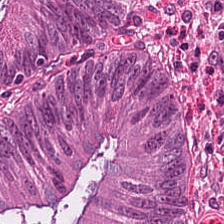

In [7]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [8]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

##HistologyTorchDataset

Назначение: адаптер между исходным Dataset (с .images и .labels) и torch.utils.data.DataLoader.

__init__(base_dataset, augment=True)

1) base_dataset — объект с полями images (numpy-массив N×H×W×3) и labels.

2) augment=True — включить аугментации.

3) Внутри собирается пайплайн трансформаций: 1) ToPILImage() — перевод np.ndarray → PIL.Image;

- если augment=True — случайные флипы, повороты, ColorJitter;

- ToTensor() — перевод обратно в тензор PyTorch в диапазоне [0,1].

- __len__ — возвращает количество изображений в датасете.

4) __getitem__(idx)

- Берёт img = base.images[idx], label = base.labels[idx].

- Применяет трансформации к img.

- Возвращает (img_tensor, label).

In [9]:
class HistologyTorchDataset(TorchDataset):
    """
    Обёртка над Dataset, у которого есть .images (N,H,W,3) и .labels (N,)
    """
    def __init__(self, base_dataset, augment: bool = True):
        self.base = base_dataset
        self.augment = augment

        transforms = [T.ToPILImage()]  # np.ndarray -> PIL

        if self.augment: #LBL_AUG
            transforms += [
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomRotation(15),
                T.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.02
                ),
            ]

        transforms.append(T.ToTensor())  # -> tensor [0,1]
        self.transform = T.Compose(transforms)

    def __len__(self):
        return len(self.base.images)

    def __getitem__(self, idx):
        img = self.base.images[idx]          # np.ndarray (H,W,3)
        label = int(self.base.labels[idx])   # int
        img = self.transform(img)            # torch.Tensor (C,H,W)
        return img, label


### Пример использвания класса HistologyTorchDataset

In [10]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset
Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [0, 3, 6, 3, 3, 4, 2, 1]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [11]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

##SimpleCNN

__init__(num_classes=9)

- Определяет сверточную часть (self.features): четыре блока Conv → BatchNorm → ReLU → MaxPool.

- Определяет:

- - self.flatten — выпрямление карты признаков;

- - self.fc_embed — линейный слой до 512-мерного эмбеддинга;

- - self.relu — нелинейность;

- - self.dropout — регуляризация;

- - self.fc_out — финальный линейный слой до 9 логитов.

forward_features(x)

- Прогоняет вход через self.features, затем flatten + fc_embed + relu.

- Возвращает эмбеддинг размера (batch_size, 512).

- Используется для извлечения признаков для SVM.

forward(x)

- Вызов forward_features(x), затем dropout и fc_out.

- Возвращает логиты классов (до softmax).

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 9):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 112x112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 56x56

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 28x28

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 14x14
        )
        # отдельно делаем "эмбеддинговый" слой и классификатор
        self.flatten = nn.Flatten()
        self.fc_embed = nn.Linear(256 * 14 * 14, 512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)

    def forward_features(self, x):
        """
        Возвращает эмбеддинг (512-мерный вектор на картинку).
        """
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc_embed(x)
        x = self.relu(x)
        return x  # (N, 512)

    def forward(self, x):
        """
        Полный прямой проход до логитов классов.
        """
        x = self.forward_features(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

Назначение: создать подмножество исходного Dataset (train/val сплит).

__init__(base_dataset, indices)

- indices — список/массив индексов.

- Вырезает images и labels только по этим индексам:
self.images = base_dataset.images[indices],
self.labels = base_dataset.labels[indices].

Используется для разбиения исходного train на обучающую и валидационную части.

In [13]:
class NumpySubsetDataset:
    """
    Подмножество исходного Dataset (по индексам),
    но с тем же интерфейсом .images, .labels
    """
    def __init__(self, base_dataset, indices):
        self.images = base_dataset.images[indices]
        self.labels = base_dataset.labels[indices]


Model — это «обёртка» над всей логикой решения задачи:
в одном месте сосредоточены

- архитектура нейросетевой части,

- процедура обучения с валидацией и early stopping,

- извлечение признаков (эмбеддингов),

- классический классификатор поверх этих признаков,

- ансамблирование,

- сохранение/загрузка весов (в том числе из облака),

- удобные методы test_on_image и test_on_dataset для оценки качества.

Вместо того чтобы ограничиться только одной нейросетью, в работе применён ансамбль из двух моделей, работающих в разных представлениях, но над одними и теми же данными:

CNN как извлекатель признаков и классификатор

- Сверточная сеть хорошо «видит» локальные структуры и текстуры на гистологических изображениях, автоматически выделяя сложные признаки.

- Финальный полносвязный слой реализует нелинейную границу между классами в пространстве эмбеддингов.

SVM как отдельный классификатор на том же признаковом пространстве

- SVM с RBF-ядром строит максимальный разделяющий зазор между классами в 512-мерном пространстве эмбеддингов.

- Такой метод часто лучше ведёт себя на относительно небольших выборках и может быть более устойчив к переобучению, чем «чистый» линейный слой сети.

- Нормировка эмбеддингов и балансировка классов помогают SVM лучше работать на дисбалансных тестовых наборах (важно из-за скрытого теста с изменённым распределением классов).

Ансамблирование вероятностей

- Для каждого изображения считаются:

- - p_cnn - вероятности классов по выходу CNN (softmax по логитам);

- - p_svm - вероятности по SVM (через predict_proba на эмбеддингах).

- Итоговый прогноз получается усреднением:

p = 1/2 * p_cnn + 1/2 * p_svm

и выбором класса по максимальной вероятности.

Такой ансамбль даёт несколько преимуществ:

- Разнообразие ошибок. CNN и SVM ошибаются не всегда на одних и тех же объектах; усреднение вероятностей сглаживает «специфические» ошибки каждой модели.

- Устойчивость к сдвигу распределения. При изменении пропорций классов и текстур (скрытые тесты) SVM по эмбеддингам часто ведёт себя более стабильно, поэтому ансамбль в среднем лучше, чем любая из двух моделей по отдельности.

- Использование сильных сторон обеих миров. CNN отвечает за «глубокое» представление признаков, SVM — за аккуратную, хорошо регуляризованную границу между классами; вместе они дают более высокую точность и меньший лосс.

В результате Model реализует не просто один классификатор, а полный ансамблевый пайплайн «глубокие признаки + классическая модель», что улучшает качество

In [14]:
import copy
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ID файлов с весами модели в Google Drive
CNN_WEIGHTS_ID = "18XgZAi36mv3BLsrln9zkKsPe7tWHNl0P"
SVM_WEIGHTS_ID = "1jnBk0umBKuwV9Kyd8egeJgm-upRbiZzY"

# модели без дообучения
#CNN_WEIGHTS_ID = "1YHDcsvjOPqjHbpt2YFHkEr9iIonZe4v9"
#SVM_WEIGHTS_ID = "1_HAr1pkDFfhpxyxgVWliWlosa-EwcMx4"

class Model:
    """
    CNN + валидация + early stopping + SVM по эмбеддингам + ансамбль CNN+SVM.
    """

    def __init__(self,
                 num_classes: int = 9,
                 lr: float = 1e-3,
                 weight_decay: float = 1e-4,
                 epochs: int = 30,
                 batch_size: int = 64,
                 val_split: float = 0.2,
                 patience: int = 5,
                 use_ensemble: bool = True):
        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_split = val_split
        self.patience = patience
        self.use_ensemble = use_ensemble

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = SimpleCNN(num_classes=self.num_classes).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.lr,
                                    weight_decay=self.weight_decay)

        # --- история обучения ---
        self.history = {
            "epoch": [],
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

        # часть для SVM по эмбеддингам
        self.embed_scaler = None
        self.embed_svm = None   # SVC(probability=True)

    # ---------- Обучение CNN с валидацией и early stopping ----------
    def train(self, d_train):
        """
        d_train — Dataset с .images и .labels
        """

        imgs = d_train.images
        labels = d_train.labels
        n = len(imgs)
        idx = np.arange(n)

        # train/val split (стратифицированный) #LBL_VAL
        idx_train, idx_val = train_test_split(
            idx,
            test_size=self.val_split,
            stratify=labels,
            random_state=42
        )

        base_train = NumpySubsetDataset(d_train, idx_train)
        base_val = NumpySubsetDataset(d_train, idx_val)

        train_ds = HistologyTorchDataset(base_train, augment=True)
        val_ds = HistologyTorchDataset(base_val, augment=False)

        train_loader = DataLoader(train_ds,
                                  batch_size=self.batch_size,
                                  shuffle=True,
                                  num_workers=2,
                                  pin_memory=True)
        val_loader = DataLoader(val_ds,
                                batch_size=self.batch_size,
                                shuffle=False,
                                num_workers=2,
                                pin_memory=True)

        # обнуляем историю (если вдруг модель дообучаем)
        self.history = {
            "epoch": [],
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

        best_val_loss = float('inf')
        best_state = copy.deepcopy(self.model.state_dict())
        no_improve = 0

        for epoch in range(self.epochs):
            # ----- train -----
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device, dtype=torch.long)

                self.optimizer.zero_grad()
                logits = self.model(xb)
                loss = self.criterion(logits, yb)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * xb.size(0)
                _, preds = torch.max(logits, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            train_loss = running_loss / total
            train_acc = correct / total

            # ----- validation -----
            self.model.eval()
            val_loss_sum = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(self.device)
                    yb = yb.to(self.device, dtype=torch.long)

                    logits = self.model(xb)
                    loss = self.criterion(logits, yb)

                    val_loss_sum += loss.item() * xb.size(0)
                    _, preds = torch.max(logits, dim=1)
                    val_correct += (preds == yb).sum().item()
                    val_total += yb.size(0)

            val_loss = val_loss_sum / val_total
            val_acc = val_correct / val_total
            #LBL_LOG
            print(f"Epoch {epoch+1}/{self.epochs} | "
                  f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
                  f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

            # ---- Сохраняем в историю ----
            self.history["epoch"].append(epoch + 1)
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            # early stopping
            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_state = copy.deepcopy(self.model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= self.patience:
                    print("Early stopping: val_loss не улучшается.")
                    break


        # загружаем лучшие веса
        self.model.load_state_dict(best_state)
        self.model.to(self.device)
        self.model.eval()

    # ---------- Вспомогательная функция: извлечь эмбеддинги ----------
    def _extract_embeddings(self, d_set, batch_size: int = 64):
        """
        d_set — Dataset с .images/.labels.
        Возвращает (X_emb, y) — numpy-массивы.
        """
        ds = HistologyTorchDataset(d_set, augment=False)
        loader = DataLoader(ds,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

        self.model.eval()
        all_emb = []
        all_labels = []

        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(self.device)
                emb = self.model.forward_features(xb)  # (B, 512)
                emb = emb.cpu().numpy()
                all_emb.append(emb)
                all_labels.append(yb.numpy())

        X_emb = np.concatenate(all_emb, axis=0)
        y = np.concatenate(all_labels, axis=0)
        return X_emb, y

    # ---------- Обучение SVM по эмбеддингам ----------
    def train_svm_on_embeddings(self, d_train, C: float = 10.0, gamma: str = 'scale'):
        """
        После обучения CNN вызываем:
            model.train(d_train)
            model.train_svm_on_embeddings(d_train)
        """
        X_emb, y = self._extract_embeddings(d_train)

        self.embed_scaler = StandardScaler()
        X_scaled = self.embed_scaler.fit_transform(X_emb)

        svm = SVC(C=C,
                  gamma=gamma,
                  kernel='rbf',
                  probability=True,
                  class_weight='balanced',
                  random_state=42)
        svm.fit(X_scaled, y)
        self.embed_svm = svm
        print("SVM по эмбеддингам обучен.")

    # ---------- Предсказания ----------

    def _predict_cnn_probs(self, img: np.ndarray):
        """
        Вернёт probs (num_classes,) только от CNN.
        """
        self.model.eval()
        with torch.no_grad():
            transform = T.Compose([
                T.ToPILImage(),
                T.ToTensor(),
            ])
            x = transform(img)
            x = x.unsqueeze(0).to(self.device)   # (1,C,H,W)
            logits = self.model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        return probs

    def _predict_svm_probs(self, img: np.ndarray):
        """
        Вернёт probs (num_classes,) только от SVM по эмбеддингам.
        Предполагает, что embed_svm уже обучен.
        """
        assert self.embed_svm is not None, "SVM ещё не обучен (embed_svm is None)."
        assert self.embed_scaler is not None

        self.model.eval()
        with torch.no_grad():
            transform = T.Compose([
                T.ToPILImage(),
                T.ToTensor(),
            ])
            x = transform(img)
            x = x.unsqueeze(0).to(self.device)
            emb = self.model.forward_features(x)  # (1,512)
            emb = emb.cpu().numpy()
        X_scaled = self.embed_scaler.transform(emb)
        probs = self.embed_svm.predict_proba(X_scaled)[0]   # (num_classes,)
        return probs

    def test_on_image(self, img: np.ndarray) -> int:
        """
        img: (H,W,3) np.uint8
        Если SVM обучен и use_ensemble=True: усредняет CNN и SVM.
        Иначе — только CNN.
        """
        cnn_probs = self._predict_cnn_probs(img)

        if self.embed_svm is not None and self.use_ensemble:
            svm_probs = self._predict_svm_probs(img)
            probs = 0.5 * cnn_probs + 0.5 * svm_probs
        else:
            probs = cnn_probs

        pred = int(np.argmax(probs))
        return pred

    # ---------- test_on_dataset (как мы делали раньше) ----------
    def test_on_dataset(self, d_test, limit: float = 1.0): #LBL_TEST
        """
        d_test  – Dataset с .images и .labels
        limit   – если 0<limit<=1: доля датасета;
                  если >1: количество примеров.
        """
        n_total = len(d_test.images)
        if 0 < limit <= 1.0:
            n_use = int(n_total * limit)
        else:
            n_use = int(min(limit, n_total))

        preds = []
        for i in range(n_use):
            img = d_test.images[i]
            preds.append(self.test_on_image(img))
        return np.array(preds, dtype=int)

    # ---------- Сохранение / загрузка ----------
    def save(self, name: str): #LBL_SAVE
        """
        Сохраняем:
        - веса CNN
        - параметры SVM по эмбеддингам (если есть)
        """
        # CNN
        torch.save(self.model.state_dict(), f"{name}_cnn.pth")

        # SVM и scaler
        svm_bundle = {
            "embed_scaler": self.embed_scaler,
            "embed_svm": self.embed_svm,
            "num_classes": self.num_classes,
        }
        joblib.dump(svm_bundle, f"{name}_svm.joblib")

        print(f"Сохранены {name}_cnn.pth и {name}_svm.joblib")

    def load(self, name: str = "best"):
        """
        Загружает веса CNN и (опционально) SVM.
        Если локальных файлов нет, автоматически скачивает их с Google Drive.
        name: базовое имя файлов (best -> best_cnn.pth, best_svm.joblib)
        """

        cnn_path = f"{name}_cnn.pth"
        svm_path = f"{name}_svm.joblib"

        # --- 1. Если нет локального файла с весами CNN, качаем из облака --- #LBL_LOAD1
        if not os.path.exists(cnn_path):
            print(f"[load] {cnn_path} не найден, скачиваю из Google Drive...")
            url_cnn = f"https://drive.google.com/uc?export=download&confirm=pbef&id={CNN_WEIGHTS_ID}"
            gdown.download(url_cnn, cnn_path, quiet=False)

        # --- 2. Аналогично для файла с SVM (может быть, не обязателен) ---
        if not os.path.exists(svm_path):
            print(f"[load] {svm_path} не найден, пытаюсь скачать из Google Drive...")
            url_svm = f"https://drive.google.com/uc?export=download&confirm=pbef&id={SVM_WEIGHTS_ID}"
            # если файла действительно нет в облаке – просто выведет предупреждение
            try:
                gdown.download(url_svm, svm_path, quiet=False)
            except Exception as e:
                print(f"[load] Не удалось скачать SVM: {e}")
                print("[load] Продолжаю только с CNN-частью.")

        # --- 3. Загружаем веса CNN --- #LBL_LOAD2
        state_dict = torch.load(cnn_path, map_location=self.device)
        self.model = SimpleCNN(num_classes=self.num_classes).to(self.device)
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()
        print(f"[load] Веса CNN загружены из {cnn_path}")

        # --- 4. Пытаемся загрузить SVM, если файл есть ---
        if os.path.exists(svm_path):
            svm_bundle = joblib.load(svm_path)
            self.embed_scaler = svm_bundle["embed_scaler"]
            self.embed_svm = svm_bundle["embed_svm"]
            self.num_classes = svm_bundle.get("num_classes", self.num_classes)
            print(f"[load] SVM по эмбеддингам загружен из {svm_path}")
        else:
            print("[load] Файл с SVM не найден, будет использована только CNN-часть.")


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [15]:
d_train = Dataset('train')
d_test = Dataset('test')

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [16]:
model = Model(epochs=30, patience=10, use_ensemble=True)

if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    # здесь уже должны быть загружены веса в load()
    model.load('best')

Epoch 1/30 | train_loss=2.9266, train_acc=0.2790 | val_loss=1.7359, val_acc=0.3569
Epoch 2/30 | train_loss=1.4963, train_acc=0.4156 | val_loss=1.7912, val_acc=0.2817
Epoch 3/30 | train_loss=1.3412, train_acc=0.4722 | val_loss=1.2148, val_acc=0.4997
Epoch 4/30 | train_loss=1.2777, train_acc=0.4981 | val_loss=1.8092, val_acc=0.4006
Epoch 5/30 | train_loss=1.1770, train_acc=0.5396 | val_loss=1.2680, val_acc=0.4933
Epoch 6/30 | train_loss=1.0953, train_acc=0.5703 | val_loss=1.0882, val_acc=0.5903
Epoch 7/30 | train_loss=1.0546, train_acc=0.5905 | val_loss=1.0631, val_acc=0.6081
Epoch 8/30 | train_loss=1.0194, train_acc=0.6012 | val_loss=0.9220, val_acc=0.6572
Epoch 9/30 | train_loss=0.9477, train_acc=0.6280 | val_loss=0.6920, val_acc=0.7506
Epoch 10/30 | train_loss=0.9028, train_acc=0.6536 | val_loss=2.4779, val_acc=0.3669
Epoch 11/30 | train_loss=0.8914, train_acc=0.6571 | val_loss=0.9110, val_acc=0.6764
Epoch 12/30 | train_loss=0.8263, train_acc=0.6844 | val_loss=0.7498, val_acc=0.7197
E

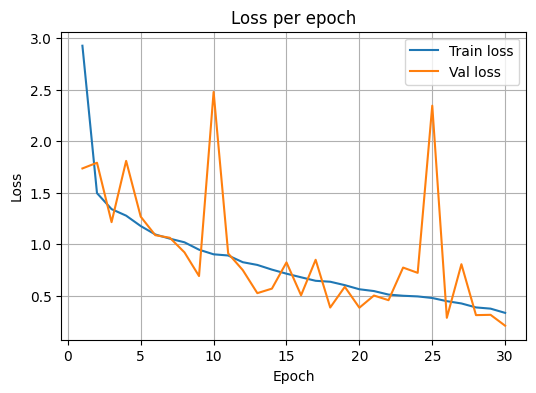

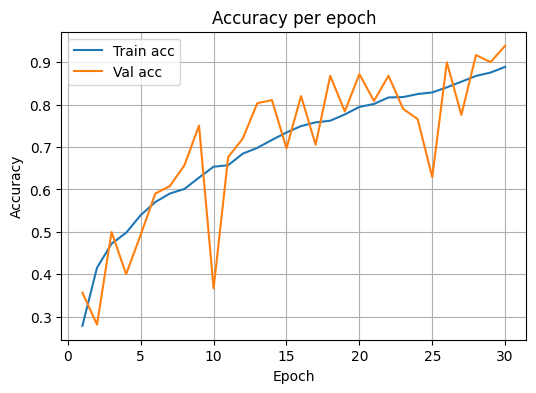

In [17]:
import matplotlib.pyplot as plt

history = model.history

epochs = history["epoch"]

plt.figure(figsize=(6,4)) #LBL_PLOTS
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.train_svm_on_embeddings(d_train)
model.save('best_emb')

SVM по эмбеддингам обучен.
Сохранены best_emb_cnn.pth и best_emb_svm.joblib


Пример тестирования модели на части набора данных:

In [19]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

metrics for 10% of test:
	 accuracy 0.9800:
	 balanced accuracy 0.9800:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [20]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

metrics for test:
	 accuracy 0.9564:
	 balanced accuracy 0.9564:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [21]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

[load] Веса CNN загружены из best_cnn.pth
[load] SVM по эмбеддингам загружен из best_svm.joblib
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
metrics for test-tiny:
	 accuracy 0.8889:
	 balanced accuracy 0.8889:


In [22]:
final_model = Model()
final_model.load('best_emb')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

[load] Веса CNN загружены из best_emb_cnn.pth
[load] SVM по эмбеддингам загружен из best_emb_svm.joblib
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
metrics for test-tiny:
	 accuracy 0.9333:
	 balanced accuracy 0.9333:


Отмонтировать Google Drive.

In [23]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"